# Utils

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

In [2]:
import pickle

def get_tree_dict(pickle_path):
    try: 
        with open(pickle_path, 'rb') as file:
            tree = pickle.load(file)
            return tree
    except:
        print("Can't open file!")

In [3]:
def get_root_id(tree_dict):
    for key, item in tree_dict.items():
        if item['pnode_id'] == -1:
            root_id = key
    return root_id

In [4]:
import treelib

def visualize_rst_tree(tree_dict, root_id, edu_list, new_relation=False, get_edu_text=False):
    rst_tree = treelib.Tree()
    relation_key = 'relation' if not new_relation else 'new_relation'
    node_list = [root_id]

    while node_list:
        id = node_list.pop()
        node = tree_dict[id]
        if (tree_dict.get(node['lnode_id']) is None) and (tree_dict.get(node['rnode_id']) is None):
            node_text = " EDU " + str(node['edu_span'])
            if get_edu_text:
                node_text += ": " + edu_list[node['edu_span'][0] - 1]
            rst_tree.create_node(node_text, id, parent=node['pnode_id'])
        else:
            node_text = node['node_form']

            if node['node_form'] == 'NN':
                node_text += "-" + tree_dict[node['rnode_id']][relation_key]
            elif node['node_form'] == 'NS':
                node_text += "-" + tree_dict[node['rnode_id']][relation_key]
            elif node['node_form'] == 'SN':
                node_text += "-" + tree_dict[node['lnode_id']][relation_key]
            else:
                raise ValueError("Unrecognized N-S form")
            
            if rst_tree.get_node(node['pnode_id']) is not None:
                rst_tree.create_node(node_text, id, parent=node['pnode_id'])
            else:
                rst_tree.create_node(node_text, id)
                print("\nNo parent at node: ", node_text, '\n')

        if tree_dict.get(node['rnode_id']) is not None:
            node_list.append(node['rnode_id'])
        if tree_dict.get(node['lnode_id']) is not None:
            node_list.append(node['lnode_id'])

    return rst_tree

In [5]:
def get_edus_from_file(edu_path):
    """Get EDUs from .edu file and return a list of EDUs
    """
    edus = []
    try: 
        with open(edu_path, 'r') as file:
            for line in file:
                if not line.strip():
                    continue
                edus.append(line.rstrip('\n'))
        return edus    
    except FileNotFoundError:
        print("Error: File not found!")


In [6]:
def extract_segments(edu_list, tree_dict, root_id): # use this when unpickling
    """Extract text segments from (1 or several EDUs) for relation labeller to read from (and make predictions)

    Args:
        edu_list: list containing EDUs (list)
        tree_dict: dict containing tree (dict)

    Return:
        Dict containing text of nucleus, satellite, and original relation from StageDP (dict)
    """

    segments = {'pnode_id': [], 'nucleus': [], 'satellite': [], 'original_relation': []} # if multi-nuclear, satellite represent second nucleus
    node_list = [root_id]
    while node_list:
        id = node_list.pop()
        node = tree_dict[id]

        if (tree_dict.get(node['lnode_id']) is None) and (tree_dict.get(node['rnode_id']) is None): # node is EDU
            continue
    
        left_edu_span = tree_dict[node['lnode_id']]['edu_span'] # tuple: (from, to)
        right_edu_span = tree_dict[node['rnode_id']]['edu_span'] # tuple: (from, to)
        
        # get corresponding text segments
        left_segment = ""
        for edu in range(left_edu_span[0], left_edu_span[1] + 1):
            left_segment += edu_list[edu - 1].strip() + ' '

        right_segment = ""
        for edu in range(right_edu_span[0], right_edu_span[1] + 1):
            right_segment += edu_list[edu - 1].strip() + ' '

        if node['node_form'] == 'NN':
            nucleus = left_segment
            satellite = right_segment
            relation = tree_dict[node['rnode_id']]['relation']
        elif node['node_form'] == 'NS':
            nucleus = left_segment
            satellite = right_segment
            relation = tree_dict[node['rnode_id']]['relation']
        elif node['node_form'] == 'SN':
            nucleus = right_segment
            satellite = left_segment
            relation = tree_dict[node['lnode_id']]['relation']

        segments['nucleus'].append(nucleus)
        segments['satellite'].append(satellite)
        segments['original_relation'].append(relation)
        segments['pnode_id'].append(id)  
        
        if tree_dict.get(node['lnode_id']) is not None:
            node_list.append(node['lnode_id'])
        if tree_dict.get(node['rnode_id']) is not None:
            node_list.append(node['rnode_id'])
    
    return segments

In [7]:
import copy
def add_new_relations_to_tree_dict(tree_dict, new_relations):
    """Extract text segments from (1 or several EDUs) for relation labeller to read from (and make predictions)

    Args:
        tree_dict: dict containing tree (dict)
        new_relations: df containing parent id and new relations (and other components no considered in this method)

    Return:
        New modified tree_dict according to new relations identified
    """
    tree_dict_c = copy.deepcopy(tree_dict)
    for _, r in new_relations.iterrows():
        p_id = r['pnode_id']
        rel = r['new_relation']
        if tree_dict_c[p_id]['node_form'] == 'NN':
            tree_dict_c[tree_dict_c[p_id]['rnode_id']]['new_relation'] = rel
            tree_dict_c[tree_dict_c[p_id]['lnode_id']]['new_relation'] = rel
        elif tree_dict_c[p_id]['node_form'] == 'NS':
            tree_dict_c[tree_dict_c[p_id]['rnode_id']]['new_relation'] = rel
        elif tree_dict_c[p_id]['node_form'] == 'SN':
            tree_dict_c[tree_dict_c[p_id]['lnode_id']]['new_relation'] = rel
        
    return tree_dict_c 

In [5]:
def write_to_text_file(text_path, text):
    """Write string in text to text_path. The text is to be analyzed using RST and generated questions from. 

    Args:
        text_path (str): path of file to write to
        text (str): text to write to (informational text to extract questions from)
    """

    try:
        with open(text_path, 'w') as f:
            f.write(text)
    except:
        print("Can't open text file!\n")

In [6]:
# run this cell to start processing text

raw_original_text = """Depending on your budget, need for speed and precision required, each algorithm type—supervised, unsupervised, semi-supervised, or reinforcement—has its own advantages and disadvantages. For example, decision tree algorithms are used for both predicting numerical values (regression problems) and classifying data into categories. Decision trees use a branching sequence of linked decisions that may be represented with a tree diagram. A prime advantage of decision trees is that they are easier to validate and audit than a neural network. The bad news is that they can be more unstable than other decision predictors. Overall, there are many advantages to machine learning that businesses can leverage for new efficiencies. These include machine learning identifying patterns and trends in massive volumes of data that humans might not spot at all. And this analysis requires little human intervention: just feed in the dataset of interest and let the machine learning system assemble and refine its own algorithms—which will continually improve with more data input over time. Customers and users can enjoy a more personalized experience as the model learns more with every experience with that person. On the downside, machine learning requires large training datasets that are accurate and unbiased. GIGO is the operative factor: garbage in / garbage out. Gathering sufficient data and having a system robust enough to run it might also be a drain on resources. Machine learning can also be prone to error, depending on the input. With too small a sample, the system could produce a perfectly logical algorithm that is completely wrong or misleading. To avoid wasting budget or displeasing customers, organizations should act on the answers only when there is high confidence in the output. Here are just a few examples of machine learning you might encounter every day:
Speech recognition: It is also known as automatic speech recognition (ASR), computer speech recognition, or speech-to-text, and it is a capability which uses natural language processing (NLP) to translate human speech into a written format. Many mobile devices incorporate speech recognition into their systems to conduct voice search—e.g. Siri—or improve accessibility for texting.
Customer service:  Online chatbots are replacing human agents along the customer journey, changing the way we think about customer engagement across websites and social media platforms. Chatbots answer frequently asked questions (FAQs) about topics such as shipping, or provide personalized advice, cross-selling products or suggesting sizes for users. Examples include virtual agents on e-commerce sites; messaging bots, using Slack and Facebook Messenger; and tasks usually done by virtual assistants and voice assistants."""
raw_original_text = raw_original_text.replace(u"\u2018", "'").replace(u"\u2019", "'").replace(u"\u2013", "-").replace(u"\u2014", "-").replace(u"\u201C", "-").replace(u"\u201D", "-") 
text_path = "../parsers-from-github/StageDP_2/data/my_sample/sample"

write_to_text_file(text_path, raw_original_text)

In [10]:
len(raw_original_text.split())

416

In [11]:
# run this cell to process new data, adjust paths if necessary

pickle_path = "../parsers-from-github/StageDP_2/data/my_sample/sample.pickle"
edu_path = "../parsers-from-github/StageDP_2/data/my_sample/sample.edus"

tree_dict = get_tree_dict(pickle_path)
root_id = get_root_id(tree_dict)
edus = get_edus_from_file(edu_path)
rst_tree = visualize_rst_tree(tree_dict, root_id, edus, get_edu_text=True)

# print(rst_tree.show(stdout=False, sorting=False)) # uncomment to visualize RST tree
# print(edus)

segments = extract_segments(edus, tree_dict, root_id)
df = pd.DataFrame(segments)
df.shape


No parent at node:  NS-Elaboration 



(41, 4)

In [12]:
# assembly the whole piece of text from EDUs, to ensure allignment

original_text = ""
for edu in edus:
    original_text += edu.strip() + ' '

In [13]:
# map "Comparison" to "Join" since GUM does not contain "Comparison"
for row in df[df['original_relation'] == 'Comparison'].iterrows():
    df.at[row[0], 'original_relation'] = "Joint"

# Relation Labeller

In [14]:
# run this cell only once
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "output_train_all_with_additional_reverse_dataset1/checkpoint-45000"
if 'tokenizer' not in locals(): # prevent accidental re-run of cell
    tokenizer = AutoTokenizer.from_pretrained(model_path)

if 'model' not in locals(): # prevent accidental re-run of cell
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(torch.device('cuda'))

/mnt/e/TOM/HUST/20232/rst-relations-labeller/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preprocess Data

In [15]:
# get labels
from sklearn.preprocessing import LabelEncoder
label_text = ['Attribution', 'Background', 'Cause', 'Condition', 'Contrast',
       'Elaboration', 'Enablement', 'Evaluation', 'Explanation', 'Joint',
       'Manner-Means', 'Same-Unit', 'Summary', 'Temporal',
       'Textual-Organization', 'Topic-Change', 'Topic-Comment']

label_shorthand = ['Attr', 'Bckg', 'Cause', 'Cond', 'Contst',
       'Elab', 'Enab', 'Eval', 'Expl', 'Joint',
       'Man-Mean', 'Same-Un', 'Sum', 'Temp',
       'Text-Org', 'Top-Chang', 'Top-Com']

le = LabelEncoder()
le.fit(label_text)
labels = le.transform(df.original_relation)

In [16]:
# adding <sep> token between nucleus and satellite
separation_token = "[SEP]"
input_sentences = df.apply(lambda x: ''.join([x['nucleus'], separation_token, x['satellite']]), axis=1)

In [17]:
# merge input sentence and labels onto one list (to form dataset object later)
data = []
for text in input_sentences:
    datapoint = {'text': text}
    data.append(datapoint)
data = np.array(data)

In [18]:
# tokenize
import datasets

def tokenize_function(dataset):
    return tokenizer(dataset["text"], padding=True, truncation=True, return_tensors='pt')

Inference

Batch Inference

In [19]:
device = 'cuda'
model.to(device)
model.eval()

batch_size = 32
dataset = datasets.Dataset.from_list(list(data))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

pred_labels = []

with torch.no_grad():
    for batch in dataloader:
        tokens = tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt').to(device)
        output = model(**tokens)
        logits = torch.Tensor.cpu(output.logits)
        pred_labels.extend(np.argmax(logits, axis=-1).tolist())

In [20]:
preds = le.inverse_transform(pred_labels)
df['new_relation'] = preds

In [21]:
# calculate porportion of changed labels

diff = df.apply(lambda x: x['original_relation'] != x['new_relation'], axis=1)
print(diff.sum(), "changed relations out of", df.shape[0], '(' + str(round(float(diff.sum()/df.shape[0]), 2)) + ')')
df[diff]

21 changed relations out of 41 (0.51)


,pnode_id,nucleus,satellite,original_relation,new_relation
1,140167423060288,"For example, decision tree algorithms are used for both predicting numerical values (regression problems) and classifying data into categories. Decision trees use a branching sequence of linked decisions that may be represented with a tree diagram. A prime advantage of decision trees is that they are easier to validate and audit than a neural network. The bad news is that they can be more unstable than other decision predictors.","Overall, there are many advantages to machine learning that businesses can leverage for new efficiencies. These include machine learning identifying patterns and trends in massive volumes of data that humans might not spot at all. And this analysis requires little human intervention: just feed in the dataset of interest and let the machine learning system assemble and refine its own algorithms -which will continually improve with more data input over time. Customers and users can enjoy a more personalized experience as the model learns more with every experience with that person. On the downside, machine learning requires large training datasets that are accurate and unbiased. GIGO is the operative factor: garbage in / garbage out. Gathering sufficient data and having a system robust enough to run it might also be a drain on resources. Machine learning can also be prone to error, depending on the input. With too small a sample, the system could produce a perfectly logical algorithm that is completely wrong or misleading. To avoid wasting budget or displeasing customers, organizations should act on the answers only when there is high confidence in the output. Here are just a few examples of machine learning you might encounter every day: Speech recognition: It is also known as automatic speech recognition (ASR), computer speech recognition, or speech-to-text, and it is a capability which uses natural language processing (NLP) to translate human speech into a written format. Many mobile devices incorporate speech recognition into their systems to conduct voice search-e.g. Siri-or improve accessibility for texting. Customer service: Online chatbots are replacing human agents along the customer journey, changing the way we think about customer engagement across websites and social media platforms. Chatbots answer frequently asked questions (FAQs) about topics such as shipping, or provide personalized advice, cross-selling products or suggesting sizes for users. Examples include virtual agents on e-commerce sites ; messaging bots, using Slack and Facebook Messenger ; and tasks usually done by virtual assistants and voice assistants.",Joint,Topic-Change
2,140167423060176,"Overall, there are many advantages to machine learning that businesses can leverage for new efficiencies.","These include machine learning identifying patterns and trends in massive volumes of data that humans might not spot at all. And this analysis requires little human intervention: just feed in the dataset of interest and let the machine learning system assemble and refine its own algorithms -which will continually improve with more data input over time. Customers and users can enjoy a more personalized experience as the model learns more with every experience with that person. On the downside, machine learning requires large training datasets that are accurate and unbiased. GIGO is the operative factor: garbage in / garbage out. Gathering sufficient data and having a system robust enough to run it might also be a drain on resources. Machine learning can also be prone to error, depending on the input. With too small a sample, the system could produce a perfectly logical algorithm that is completely wrong or misleading. To avoid wasting budget or displeasing customers, organizations should act on the answers only when there is high confidence in the output. Here are just a few examples of machine learning you might encounter every day: Speech recognition: It 

In [22]:
# fix old tree with new relations

new_tree_dict = add_new_relations_to_tree_dict(tree_dict, df)
new_rst_tree = visualize_rst_tree(new_tree_dict, get_root_id(new_tree_dict), edus, new_relation=True, get_edu_text=True)

print(new_rst_tree.show(stdout=False, sorting=False)) # for visualizing rst_tree


No parent at node:  NS-Elaboration 

NS-Elaboration
├── NN-Background
│   ├──  EDU (1, 1): Depending on your budget, need for speed and precision required,
│   └──  EDU (2, 2): each algorithm type-supervised, unsupervised, semi-supervised, or reinforcement-has its own advantages and disadvantages.
└── NN-Topic-Change
    ├── NN-Elaboration
    │   ├──  EDU (3, 3): For example, decision tree algorithms are used for both predicting numerical values (regression problems) and classifying data into categories.
    │   └── NN-Contrast
    │       ├── NS-Topic-Change
    │       │   ├── NS-Elaboration
    │       │   │   ├──  EDU (4, 4): Decision trees use a branching sequence of linked decisions
    │       │   │   └──  EDU (5, 5): that may be represented with a tree diagram.
    │       │   └──  EDU (6, 6): A prime advantage of decision trees is that they are easier to validate and audit than a neural network.
    │       └──  EDU (7, 7): The bad news is that they can be more unstable than

<BarContainer object of 13 artists>

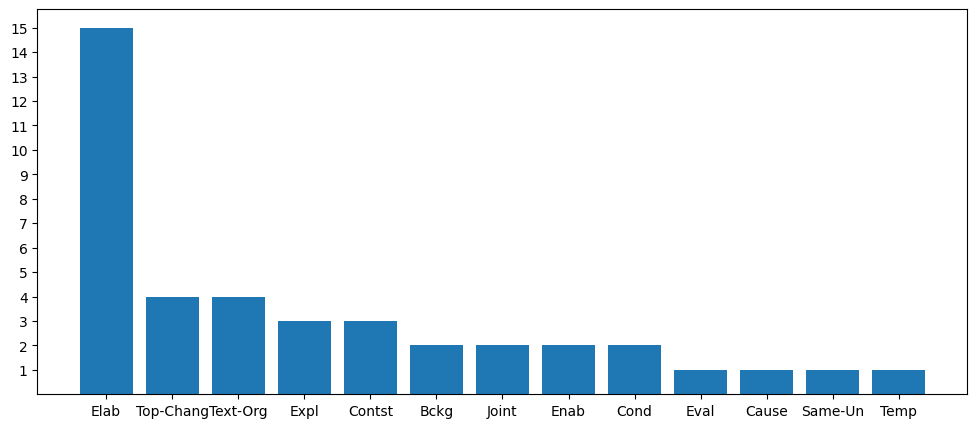

In [23]:
label_cnt = pd.Series(pred_labels).value_counts()
indices = pd.Series(label_shorthand).reindex(label_cnt.index, fill_value=0)

plt.figure(figsize=(12, 5))
plt.yticks(np.arange(1, max(label_cnt) + 1))
plt.bar(indices, label_cnt)

In [24]:
# find occurences of a specific relation

df[df["original_relation"] == "Cause"]

,pnode_id,nucleus,satellite,original_relation,new_relation


In [25]:
# find occurences of a specific relation

df[df["new_relation"] == "Cause"]

,pnode_id,nucleus,satellite,original_relation,new_relation
19,140167423059000,"Online chatbots are replacing human agents along the customer journey,",changing the way we think about customer engagement across websites and social media platforms.,Elaboration,Cause


Individual Inference

In [26]:
device = 'cuda'
model.to(device)
model.eval()

sep = tokenizer.sep_token
text_n = "She used the tool in the garden, "
text_s = "in order to win."
text = text_n + sep + text_s

with torch.no_grad():
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
    output = model(**tokens)
    logits = torch.Tensor.cpu(output.logits)
    single_pred = int(np.argmax(logits, axis=-1))
    
le.inverse_transform([single_pred])[0]

'Enablement'

# Question Generation

Utils

In [27]:
RELATIVE_PRONOUNS = ['who', 'that', 'whose', 'which']

In [28]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_trf')
nlp_small = spacy.load("en_core_web_sm")

In [29]:
def get_subj(clause, accept_pron=True, accept_expl=False):
    """Return subject of clause, None of none found

    Args:
        clause (str): 
        accept_expl (bool, optional): If take expletive as subject. Defaults to False.
        accept_expl (bool, optional): If take pronoun as subject. Defaults to True.

    Returns:
        str: The subject
    """
    doc = nlp(clause)

    for token in doc:
        if 'nsubj' in token.dep_:
            if token.pos_ == "PRON" and not accept_pron:
                continue
            for chunk in doc.noun_chunks:
                if chunk.start <= token.i and token.i < chunk.end:
                    return chunk.text
        if accept_expl:
            if 'expl' in token.dep_:
                return token.text
    return None

In [30]:
# WORKING: make a more fool proof method of checking relative clause: inputing both source sents and text, and use pos tags to determine, refer to : is_dependent_clause()
def check_relative_clause(text):
    """Return if the text (has to contain only one clause) is a relative clause, 
    relative clauses can start with "which", "Ving, "Ved" (not including adverbial clause)

    Args:
        text
    Return
        boolean
    """
    doc = nlp(text)

    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if (token.dep_ == "nsubj"):
                if (token.text.lower() in RELATIVE_PRONOUNS):
                    return 1 # relative clause starting with relative pronouns
                break

    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if (token.pos_ == "VERB") and (token.tag_ in ['VBG', 'VBN']):
                # WORKING: Change way to check tense, use tag_ instead of morph
                if len(token.morph.get('Tense')) == 0:
                    return 0 # not relative clause
                if (token.text.endswith('ing')) or (token.tag_ ==  'VBN'):
                    return 2 # shortened relative clause (ending with Ving or Ved)
            else: 
                return 0

In [31]:
def find_boundary(sent_doc, text_doc):
    """Find boundary indices of text_doc in sent_doc (given that text_doc is in sent_doc)

    Args:
        sent_doc (nlp Doc): 
        text_doc (nlp Doc): 
    """
    start_ind = 0
    while start_ind < len(sent_doc):
        if text_doc.text not in sent_doc[start_ind:].text:
            break
        start_ind += 1
    start_ind -= 1

    end_ind = len(sent_doc)
    while end_ind > 0:
        if (text_doc.text not in sent_doc[:end_ind].text) or (end_ind <= start_ind):
            break
        end_ind -= 1
    end_ind += 1

    return start_ind, end_ind

def is_dependent_clause(src_sent, text):
    # WORKING: may use this way to check relative clause as well
    sent_doc = nlp(src_sent)
    text_doc = nlp(text)   

    start_ind, end_ind = find_boundary(sent_doc, text_doc)
    if start_ind < 0 or end_ind > len(sent_doc):
        print("\nText not found in source sentence!\n")
        return None

    for token in sent_doc[start_ind:end_ind]:
        if token.dep_ in ['acl', 'advcl', 'xcomp']: # omitted "ccomp", put back again if needed
            if token.head.i in range(start_ind, end_ind):
                return False
            return True
    return False     

In [32]:
import inflect
p = inflect.engine()

def unshorten_relative_clause(original_sent, clause):
    """Unshorten relative clause (make sure it's a relative clause before calling this method) ending with Ving or Ved, convert them to which/who + V

    Args:
        clause (str): relative clause containing Ving or Ved
        original_sent (str): original sentence containing that clause
    Return:
        tuple(str, str): modified clause and source sentence
    """

    clause_doc = nlp(clause)
    text_doc = nlp(original_sent)
    vb = ""

    for token in clause_doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if (token.pos_ == "VERB") and (token.tag_ in ['VBG', 'VBN']): # finds Ving or Ved
                vb = token

    for v_token in text_doc:
        # find verb in original sentence
        if v_token.text == vb.text.strip():
            c_i = vb.i
            t_i = v_token.i
            is_verb = True
            while c_i < len(clause_doc) and t_i < len(text_doc):
                if clause_doc[c_i].text.strip() != text_doc[t_i].text.strip():
                    is_verb = False
                    break
                c_i += 1
                t_i += 1
            if is_verb:
                break
    
    pointed_noun = v_token.head
    pointed_noun_chunk = None
    for chunk in text_doc.noun_chunks:
        if chunk.start <= pointed_noun.i and pointed_noun.i < chunk.end:
            pointed_noun_chunk = chunk
    
    if pointed_noun_chunk:
        pointed_root_noun = pointed_noun_chunk.root
    else:
        pointed_root_noun = pointed_noun
    
    rel_pro = "which" 
    # not a fool-proof way to determine if noun is person
    if pointed_root_noun.ent_type_:
        if pointed_root_noun.ent_type_ == "PERSON":
            rel_pro = "who"

    # check plurality of noun/pronoun and conjugate accordingly
    # only applicable for Present Tense, not for past or others
    if pointed_root_noun.pos_.startswith("NOUN"): # noun
        plurality = pointed_root_noun.tag_ == "NNS"
    elif "PRON" in pointed_root_noun.pos_:  # pronoun
        plurality = (pointed_root_noun.lemma_ == "we") or (pointed_root_noun.lemma_ == "you") or (pointed_root_noun.lemma_ == "they") or ((pointed_root_noun.lemma_ == "I"))
    else: # WORKING: for other cases where relative pronoun does not point to a noun, but a verb or a clause
        plurality = False # temporary solution

    if not plurality:
        if vb.tag_ == 'VBG':
            conj_vb = p.plural_noun(vb.lemma_) # get singular conjugation (plural_noun() method works with verbs too)
        else:
            if pointed_root_noun.text.strip() == "I":
                aux = 'am'
            else:
                aux = 'is'
            conj_vb = aux + ' ' + vb.text
    else:
        if vb.tag_ == 'VGB':
            conj_vb = p.plural_verb(vb.lemma_) # get plural conjugation
        else:
            if pointed_root_noun.text.strip() == "I":
                aux = 'am'
            else:
                aux = 'are'
            conj_vb = aux + ' ' + vb.text

    fixed_clause = clause.replace(vb.text, rel_pro + ' ' +  conj_vb, 1)# replace only the first occurence of the verb
    fixed_sent = original_sent.replace(clause.strip(), fixed_clause.strip(), 1)
    return  (fixed_sent, fixed_clause)

In [33]:
unshorten_relative_clause("I saw Tom walking at midnight", "walking at midnight")

('I saw Tom which walks at midnight', 'which walks at midnight')

In [34]:
# WORKING: Need to handle all types of shortened relative clauses, for now, only Ving and Ved is covered.

In [35]:
def is_one_clause(text, count_relative_clause=True):
    """Check if input text is one clause or multiple.
        NOTE: If not multiple clause, the method returns true, so does not account for the case of not a full clause, just check whether multiple clauses or not, cause a EDU is usually at least a clause semantically. 

    Args:
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    doc = nlp(text)

    # check how many subjects
    has_subj = False
    for token in doc:
        if "nsubj" in token.dep_:
            if not count_relative_clause:
                if token.text.lower() in ['who', 'whom', 'whose', 'which', 'that']:
                    continue
                if token.head.dep_ in ['relcl', 'acl', 'ccomp']:
                    continue
            if has_subj:
                return False
            else:
                has_subj = True
    return True # not return has_subj, so that even no subject will be 1 clause

In [36]:
def has_aux(sentence):
    """Check if sentence has auxiliary verb.
    Input one sentence only.
    """
    doc = nlp(sentence)
    for token in doc:
        if "AUX" in token.pos_:
            return True
    return False

In [37]:
auxiliary_shorthand = {
    "'s": "is",
    "'re": "are",
    "'ve": "have",
    "'d": "had",
    "'ll": "will",
    "n't": "not"
}

In [38]:
def move_aux_to_beginning(sentence):
    """Move auxiliary verb to the beginning of sentence (to form question).
    Input one sentence only. Make sure it has aux verb. Make sure sentence starts with subject.
    """
    doc = nlp(sentence)
    aux = ""
    for token in doc:
        if "AUX" in token.pos_:
            aux = token.text
            break
    assert len(aux)

    if aux.strip() in auxiliary_shorthand:
        new_aux = auxiliary_shorthand[aux]
        new_sent = new_aux + ' ' + sentence.strip().replace(aux, '', 1).replace(sentence[0], sentence[0].lower(), 1)
    else:
        new_sent = aux + ' ' + sentence.strip().replace(aux, '', 1).replace(sentence[0], sentence[0].lower(), 1)

    return new_sent

In [39]:
# move aux test run

txt = "The person on the right can be her father, I can do it if not."
if has_aux(txt):
    print(move_aux_to_beginning(txt))

can the person on the right  be her father, I can do it if not.


In [40]:
def has_verb(sentence):
    """Check if sentence has normal verb.
    Input one sentence only.
    """
    doc = nlp(sentence)
    for token in doc:
        if "VERB" in token.pos_:
            return True
    return False

In [41]:
def choose_and_replace_aux_for_verb(sentence):
    """Put appropriate aux at beginnging of clause 
    """
    doc = nlp(sentence)
    main_verb = None

    for token in doc:
        if "VERB" in token.pos_:
            main_verb = token
            break
            
    if not main_verb:
        print("\nCan't find main verb in", sentence, '!\n')
        return ""
    
    # check plurality
    pointed_noun = main_verb.head
    if pointed_noun.pos_.startswith("NOUN"): # noun
        plurality = pointed_noun.tag_ == "NNS"
    elif pointed_noun.pos_.startswith("PRP"):  # pronoun
        plurality = (pointed_noun.lemma_ == "we") or (pointed_noun.lemma_ == "you") or (pointed_noun.lemma_ == "they")
    else: # WORKING: for other cases where relative pronoun does not point to a noun, but a verb or a clause
        plurality = True # temporary solution

    # check tense
    tense = "present" if main_verb.tag_ in ['VBZ', 'VBP'] else 'past'
    # get aux
    aux = {
      "present": "do" if plurality else "does",
      "past": "did",
    }.get(tense)

    # replace appropriate auxilary
    new_sent = sentence.replace(main_verb.text, main_verb.lemma_, 1)
    new_sent = aux + ' ' + new_sent

    return new_sent

In [42]:
# move verb test run

txt = "he hit down."
if has_verb(txt):
    print(choose_and_replace_aux_for_verb(txt))

did he hit down.


In [43]:
def remove_ending_special_chars(sentence):
    """Remove ending non-word characters of a sentence

    Args:
        sentence (str): sentence to be stripped

    Returns:
        str: stripped sentence 
    """
    sen_len = len(sentence)
    for i in range(sen_len - 1, -1, -1):
        char = sentence[i]

        # check if the character is a punctuation mark
        if char.isalnum():
            return sentence
        else:
            sentence = sentence[:i]
    return sentence.strip()

In [44]:
def remove_leading_special_chars(sentence):
    """Remove leading non-word characters of a sentence

    Args:
        sentence (str): sentence to be stripped

    Returns:
        str: stripped sentence 
    """

    start_ind = 0
    for i in range(0, len(sentence)):
        char = sentence[i]
        # check if the character is a punctuation mark
        if char.isalnum():
            break
        else:
            start_ind = i + 1

    return sentence[start_ind: ].strip()

In [45]:
import re
def split_into_sentences(text):
    """Split text into sentence

    Args:
        text (str): text to be plited
    Return: 
        list[str]: spit text
    """
    sents = re.split(r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)", text)
    sents = [sent for sent in sents if len(sent.strip())]
    return sents

In [46]:
def split_into_paras(text, deli):
    paras = text.split(deli)
    paras = [para.strip() for para in paras if len(para.strip()) != 0]
    return paras

In [47]:
def get_para_id(paras, text):
    """Find paragraph index of text

    Args:
        paras (list[str]): list of paragraphs
        text (str): text to find
    Return:
        int: para id, -1 if not found
    """

    for p_i in range(len(paras)):
        if paras[p_i].find(text.strip()) != -1:
            return p_i
    return -1

In [48]:
import math

def find_source_sents(sents, text, span=2):
    """Find the sentences of which the text is a part. 

    Args:
        sents (str): 
        text (str): 
        span (int): span of sentences to the left to return
    """
    start_ind = 0
    while start_ind < len(sents):
        if text not in ''.join(sents[start_ind:]):
            break
        start_ind += 1
    start_ind -= 1

    end_ind = len(sents) # exclusive
    while end_ind > 0:
        if (text not in ''.join(sents[:end_ind])) or (end_ind <= start_ind):
            break
        end_ind -= 1
    end_ind += 1

    if (start_ind < 0) or (end_ind > len(sents)):
        print(f"\nCan't find source sentences of {text}\n")
        return None
    
    src_sents = ''.join(sents[max(start_ind - span, 0):end_ind])
    return src_sents

In [49]:
def add_subject_to_relative_clause(original_sent, clause):
    """Find and Prepend (with modifications) the subject of relative clause that does not contain one

    Args:
        original_sent (str): sentence from which the clause is extracted
        clause (str): clause for which to find subject
    Return:
        str: subject
    """
    doc = nlp(original_sent)
    subj = ""
    clause_start_ind = original_sent.find(clause)
    for token in doc:
        if (len(subj)):
            break
        if (token.dep_ in ['relcl', 'acl']) and (token.idx >= clause_start_ind) and (token.idx < (clause_start_ind + len(clause))): # relative clause is noun modifier
            for chunk in doc.noun_chunks:
                if token.head.i >= chunk.start and token.head.i < chunk.end:
                    subj = chunk.text
                    break
        
        # WORKING: relative clause is verb/adverb/adjective modifier, not sure if it's necessary tho
        # 'cause adverbial clauses are often in relations that do not require unshortening of clause
        if (token.dep_ in ['advcl', 'ccomp']) and (token.idx >= clause_start_ind) and (token.idx < (clause_start_ind + len(clause))): 
            print("\nFound Adverbial Clause\n")
            return None
            # for chunk in doc.noun_chunks:
            #     if token.head.i >= chunk.start and token.head.i < chunk.end:
            #         subj = chunk.text
            #         break
                    
    if not len(subj): # not found subject
        print("\nCan't find subject of", original_sent, "!\n")
        return None         
    
    for token in doc:
        if (token.dep_ == "nsubj") and (token.text.lower() in RELATIVE_PRONOUNS):
            new_clause = clause.replace(token.text, subj) # contains more nuances (where -> in + N, which -> N, who -> N)
            new_sent = original_sent.replace(clause.strip(), new_clause.strip(), 1)
            return new_sent, new_clause

In [50]:
# add subject test run
txt ="For instance, on the MNLI task, the BERT_base accuracy improves by 1.0% when that trains on 1M steps (128,000 words batch size)"
txt_c = "that trains on 1M steps (128,000 words batch size)"
add_subject_to_relative_clause(txt, txt_c)


Found Adverbial Clause



In [51]:
def remove_leading_conjunction(original_sent, text):
    """Remove leading conjunctions from text, return intact if cannot find any

    Args:
        original_sent (_type_): _description_
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    doc = nlp(text)
    
    for token in doc:
        if token.pos_ in ['PUNCT', 'SYM']:
            continue
        if "CONJ" not in token.pos_:
            return (original_sent, text)
        conj = token.text
        break

    new_text = text.replace(conj.strip(), '', 1)
    new_sent = original_sent.replace(text, new_text)

    return (new_sent, new_text)

In [52]:
def remove_leading_adverb(original_sent, text):
    """Remove leading adverb from text, return intact if cannot find any

    Args:
        original_sent (_type_): _description_
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    doc = nlp(text)
    
    for token in doc:
        if token.pos_ in ['PUNCT', 'SYM']:
            continue
        if token.pos_ != 'ADV':
            return (original_sent, text)
        adv = token.text
        break

    new_text = text.replace(adv.strip(), '', 1)
    new_sent = original_sent.replace(text, new_text)

    return (new_sent, new_text)

In [53]:
DISCOURSE_MARKERS = [
  'accordingly', 'additionally', 'afterward', 'also',
  'although', 'as a final point', 'as a result', 'assuming that', 'because', 'this is because'
  'besides', 'but also', 'compared to', 'consequently', 'conversely', 'despite',
  'even though', 'finally', 'first', 'firstly', 'for example', 'for instance',
  'for the purpose of', 'furthermore', 'hence', 'however', 'if', 'importantly',
  'in addition', 'in case', 'in conclusion', 'in contrast', 'by contrast', 'in fact',
  'in order to', 'in other words', 'in the event that', 'in the same way',
  'indeed', 'just as', 'lastly', 'likewise', 'moreover', 'namely',
  'nevertheless', 'next', 'nonetheless', 'not only', 'of course', 'on condition that',
  'on the contrary', 'on the one hand', 'on the other hand', 'otherwise', 'plus', 'previously',
  'provided that', 'second', 'secondly', 'similarly', 'similarly to', 'since',
  'so', 'so that', 'specifically', 'subsequently', 'such as', 'that is to say', 'that is'
  'then', 'therefore', 'third', 'thirdly', 'thus', 'to conclude', 'to illustrate',
  'to put it differently', 'to sum up', 'ultimately', 'undoubtedly', 'unless',
  'while', 'with the aim of', 'yet', 'then', 'and then'
  'as a consequence', 'as a result',
]

In [54]:
import re

def remove_leading_discourse_marker(original_sent, text):
    """Remove leading discourse markers from text, return intact if cannot find any

    Args:
        original_sent (_type_): _description_
        text (_type_): _description_

    Returns:
        _type_: _description_
    """

    discourse_marker = None
    min_pos = len(text)
    for dm in DISCOURSE_MARKERS:
        find_result = text.lower().find(dm)
        if find_result > -1:
            if find_result < min_pos:
                min_pos = find_result
                discourse_marker = dm
            if find_result == min_pos and len(dm) > len(discourse_marker):
                discourse_marker = dm
    
    # check if found marker stand at the beginning of text
        
    if discourse_marker is not None:
        for i in range(0, min_pos):
            if text[i].isalnum() or text[min_pos + len(discourse_marker)].isalnum():
                discourse_marker = None
                break
            
    if not discourse_marker:
        return (original_sent, text)

    pattern = re.compile(discourse_marker, re.IGNORECASE)

    new_text = pattern.sub("", text, 1)
    new_sent = original_sent.replace(text, new_text)
    
    return (new_sent, new_text)

In [55]:
# to be integrated

def replace_substr(text, substring, start_ind, end_ind):
  """Replace part of text with specified index [start_ind, end_ind) with substring
  """
  try:
    assert(len(substring)  == end_ind - start_ind)
  except:
    print('Text:', text, '--', sep='')
    print('Substring:', substring, '--', sep='')

  text_l = list(text)
  text_l[start_ind:end_ind] = list(substring)

  return ''.join(text_l)

In [56]:
def is_in_ref(index, clusters):
    """Check if current index is in one of the references
    
    Args:
        index (int): index to check
        clusters (list(list(tuple))): list of cluster, each cluster containing a list of tuple correponding to indices of the references
    Return:
        tuple (verdict, (start, end), (ref_token_start, ref_token_end)): -1 both index if not found, ref_token is token to relace
    """
    for cluster in clusters:
        for token in cluster:
            if cluster.index(token) == 0:
                continue
            if index >= token[0] and index < token[1]:
                ref_token = (cluster[0][0], cluster[0][1])
                return True, token, ref_token
            
    return False, (-1, -1), (-1, -1)

In [57]:
def check_relative_clause_type(clause):
    """Check which type of relative clause "clause" is: 
    - which + V + clause (present subject is sufficient for being clause)
    - which + V + (not clause)

    Args:
        sent (str): 
        clause (str): 
    Return: 0 or 1, -1 if not relative clause expected (not start with which + V), then it could be an adverbial clause
    """

    doc = nlp(clause.strip())

    i = 0
    while i < len(doc):
        token = doc[i]
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" not in token.pos_: 
                return -1
            else:
                break
        i += 1

    i += 1 
    while i < len(doc):
        token = doc[i]
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "VERB" not in token.pos_ and "AUX" not in token.pos_: 
                return -1        
            else:
                break
        i += 1
    
    # if reach here, is expected relative clause type (which + V)
    i += 1
    t_i = i # use to this to check subject and not modify i
    while t_i < len(doc):
        token = doc[t_i]
        if 'nsubj' in token.dep_:
            return 0
        t_i += 1

    return 1    

In [58]:
# to be integrated
from fastcoref import FCoref, LingMessCoref
if 'coref_resolver' not in locals(): # prevent accidental re-run of cell
    coref_resolver = LingMessCoref(device='cuda:0')

def resolve_coreference(original_sent, text):
    """Perfrom coreference resolution and replace corresponding text.

    Args:
        original_sent (str): Sentence the text was derived froms
        text (str): Target text
    """

    text_ind = original_sent.find(text) # starting index of text in original text
    coref_preds = coref_resolver.predict(texts=[original_sent])
    coref_clusters = coref_preds[0].get_clusters(as_strings=False)
    new_sent = []
    new_text = []

    # interate string left to right while appending current char to a new list
    # if current index in one of the token in one of the clusters, add the replacement to the list, keep the text intact, to know what index are at
    i = 0

    # if referred word is a verb, use have to notice and discard the sentence.
    while i < len(original_sent):
        find_result = is_in_ref(i, coref_clusters)
        if find_result[0]:
            token = find_result[1]
            token_ref = find_result[2]
            new_sent.append(original_sent[token_ref[0]:token_ref[1]])
            if (i >= text_ind and i < text_ind + len(text)):
                if (text_ind <= token[0] and token[1] <= text_ind + len(text)):
                    new_text.append(original_sent[token_ref[0]:token_ref[1]])
                else:
                    new_text.append(original_sent[i:text_ind + len(text)])
            i = token[1]
        else:
            new_sent.append(original_sent[i])
            if i >= text_ind and i < text_ind + len(text):
                new_text.append(original_sent[i])
            i += 1

    return ''.join(new_sent), ''.join(new_text)

05/28/2024 18:27:41 - INFO - 	 missing_keys: []
05/28/2024 18:27:41 - INFO - 	 unexpected_keys: []
05/28/2024 18:27:41 - INFO - 	 mismatched_keys: []
05/28/2024 18:27:41 - INFO - 	 error_msgs: []
05/28/2024 18:27:41 - INFO - 	 Model Parameters: 590.0M, Transformer: 434.6M, Coref head: 155.4M


In [59]:
# coref test run    
txt = "Transformers process input sequences in parallel, making the them highly efficient for training and inference"
# sents = split_into_sentences(original_text)
# src = find_source_sents(sents, txt, 5)
# resolve_coreference(src, txt)
coref_preds = coref_resolver.predict(texts=[txt])
coref_clusters = coref_preds[0].get_clusters(as_strings=False)
coref_preds

05/28/2024 18:27:41 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00,  1.40 examples/s]
05/28/2024 18:27:42 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it]


[CorefResult(text="Transformers process input sequences in parallel, ...", clusters=[['Transformers', 'them']])]

In [60]:
def preprocessing_pipeline(original_text, text, retain_dm=False, retain_conj=False, retain_adv=False, add_subject_to_rel_clause=False):
    """Tranform raw text into a full clause to be fed to the question generation pipeline

    Args:
        text (str): raw text
    Return:
        (str): full clause from text
    """
    sents = split_into_sentences(original_text)

    # coreferen ce resolution
    src_3_sents = find_source_sents(sents, text, 3)
    src_3_sents, text = resolve_coreference(src_3_sents, text)
    src_sent = find_source_sents(split_into_sentences(src_3_sents), text, 0)

    # removal of irrelavent components
    if not retain_dm:
        src_sent, text = remove_leading_discourse_marker(src_sent, text)    
    if not retain_conj:
        src_sent, text = remove_leading_conjunction(src_sent, text)
    if not retain_adv: 
        src_sent, text = remove_leading_adverb(src_sent, text)
    src_sent = remove_leading_special_chars(src_sent)
    text = remove_leading_special_chars(text)
    # src_3_sents = remove_ending_special_chars(src_3_sents)
    # text = remove_ending_special_chars(text)

    # handle single relative clause
    if is_one_clause(text, count_relative_clause=False):
        cl_type = check_relative_clause(text)
        if cl_type != 0: # is relative clause
            if cl_type == 2:
                print("\nText here: ", src_sent, text)
                src_sent, text = unshorten_relative_clause(src_sent, text)
            if add_subject_to_rel_clause:
                # WORKING: temporary solution before fixing add_subject_to_relative_clause()
                if add_subject_to_relative_clause(src_sent, text):
                    src_sent, text = add_subject_to_relative_clause(src_sent, text)

    return src_sent, text  

In [61]:
import re

def postprocess_question(ques):
    """Clean up the question after being generated.
    Pipeline: Clean double spaces, clean extra punctuations,\ 
    add extra space before question mark (for incomplete question model to run well).

    Args:
        ques (str): generated question
    Returns:
        str: new question
    """

    puncts_to_remove = ['.', ',', '!']

    ques_c = list(ques)
    for i in range(len(ques_c) - 1, 0, -1):
        if ques_c[i].isalnum():
            break

        if ques_c[i] in puncts_to_remove:
            ques_c.pop(i)
    
    for i in range(len(ques_c) - 1, 0, -1):
        if ques_c[i] == '?':
            ques_c.insert(i, ' ')
            break

    new_ques = ''.join(ques_c)
    new_ques = re.sub(r'\s+', ' ', new_ques)
    return new_ques

In [62]:
def postprocess_answer(ans):
    """Clean up the answer after being generated.
    Pipeline: Clean double spaces, clean extra punctuations, capitalize first word.

    Args:
        ans (str): generated answer
    Returns:
        str: new answer
    """

    puncts_to_remove = ['.', ',', '!']

    ans_c = list(ans)
    has_punct = False
    for i in range(len(ans_c) - 1, 0, -1):
        if ans_c[i].isalnum():
            break

        if ans_c[i] in puncts_to_remove:
            if not has_punct:
                has_punct = True
            else:
                ans_c.pop(i)

    for i in range(len(ans_c)):
        if len(ans_c[i].strip()) == 0:
            continue
        ans_c[i] = ans_c[i].upper()
        ans_c = ans_c[i:]
        break

    new_ans = ''.join(ans_c)
    new_ans = re.sub(r'\s+', ' ', new_ans)
    return new_ans

Question Templates

WORKING: 
- Handle non-clause (maybe just keep all, discard "which + V" maybe)
- Handle missing information (two EDUs still don't make a sentence) -> maybe segment longer texts

In [63]:
def cause_question_type_0(nucleus, satellite): # WORKING: nucleus cause satellite (but now model interpret both directions, needs fixing)
    """Make question based on CAUSE relationship
    Type 0: satellite (result) is: relative clause: which + verb + clause (e.g. which made him happy.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    # experimenting:exactly the same as type_1
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)


def cause_question_type_1(nucleus, satellite):
    """Make question based on CAUSE relationship
    Type 1: satellite (result) is: relative clause: which + verb + (not clause) (e.g. which caused the noise.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

def cause_question_type_2(nucleus, satellite): 
    """Make question based on CAUSE relationship
    Type 2: satellite (result) is: full clause (not relative clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    if has_aux(satellite):
        new_sate = move_aux_to_beginning(satellite)
    else: 
        new_sate = choose_and_replace_aux_for_verb(satellite)
    question = "Why " + new_sate.strip() + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

                                             
def generate_cause_question(nucleus_pair, satellite_pair):
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]
    if is_one_clause(satellite, count_relative_clause=False):
        cl_type = check_relative_clause(satellite)
        if cl_type != 0: # is relative clause
            rel_type = check_relative_clause_type(satellite)
            if rel_type == 0:
                return cause_question_type_0(nucleus, satellite)
            elif rel_type == 1:
                return cause_question_type_1(nucleus, satellite)
    else:
        return ("", "")
    return cause_question_type_2(nucleus, satellite)

In [64]:
# contrast relation: ask what's different between two subjects.
# retain discourse markers
    
def make_contrast_question_with_two_clauses(nucleus, satellite):
    n_subj = get_subj(nucleus)
    s_subj = get_subj(satellite)
   
    if (n_subj is None) or (s_subj is None):
        print("\nCan't find subject!\n")
        return ("", "")
     
    if n_subj.strip().lower() == s_subj.strip().lower():
        print("\nSame subjects for nucleus and satellite!\n")
        return ("", "")
    
    question = "What is the difference between " + n_subj + " and " + s_subj + '?'
    answer = nucleus.strip() + ' ' + satellite.strip()
    return (question, answer)

def generate_contrast_question(nucleus_pair, satellite_pair):
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]
    
    if is_one_clause(nucleus, count_relative_clause=False) and is_one_clause(satellite, count_relative_clause=False):
        return make_contrast_question_with_two_clauses(nucleus, satellite)
    return ("", "") # more than 1 clause

In [65]:
# condition relation

def condition_question_type_0(nucleus, satellite): 
    """Make question based on condition relationship
    Type 0: satellite (result) is: relative clause: which + verb + clause (e.g. which made him happy.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    # experimenting:exactly the same as type_1
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What condition", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)


def condition_question_type_1(nucleus, satellite):
    """Make question based on condition relationship
    Type 1: satellite (result) is: relative clause: which + verb + (not clause) (e.g. which conditiond the noise.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    doc = nlp(satellite)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = satellite.replace(rel_pro.strip(), "What condition", 1) + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

def condition_question_type_2(nucleus, satellite): 
    """Make question based on condition relationship
    Type 2: satellite (result) is: full clause (not relative clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    if has_aux(satellite):
        new_sate = move_aux_to_beginning(satellite)
    else: 
        new_sate = choose_and_replace_aux_for_verb(satellite)
    question = "In what condition " + new_sate.strip() + '?'
    answer = nucleus.strip() + '.'

    return (question, answer)

                                             
def generate_condition_question(nucleus_pair, satellite_pair):
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]
    
    if is_one_clause(satellite, count_relative_clause=False):
        cl_type = check_relative_clause(satellite)
        if cl_type != 0: # is relative clause
            rel_type = check_relative_clause_type(satellite)
            if rel_type == 0:
                return condition_question_type_0(nucleus, satellite)
            elif rel_type == 1:
                return condition_question_type_1(nucleus, satellite)
        else: # 1 clause, not relative clause 
            return condition_question_type_2(nucleus, satellite)
    else:
        return ("", "")

In [66]:
# enablement relation
# difference to manner-means: enablement encapsulate manner-means, as all means can "enable" the goal,
# but enablement also contains situational aid, an event lead (may not intentionally) to another event
    
# enablement relation

def enablement_question_type_0(nucleus, satellite): 
    """Make question based on enablement relationship
    Type 0: satellite (result) is: relative clause: which + verb + clause (e.g. which made him happy.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    # experimenting: exactly the same as type_1
    doc = nlp(nucleus)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = nucleus.replace(rel_pro.strip(), "What ", 1) + '?'
    answer = satellite.strip() + '.'

    return (question, answer)


def enablement_question_type_1(nucleus, satellite):
    """Make question based on enablement relationship
    Type 1: satellite (result) is: relative clause: which + verb + (not clause) (e.g. which enablementd the noise.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    doc = nlp(nucleus)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = nucleus.replace(rel_pro.strip(), "What ", 1) + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def enablement_question_type_2(nucleus, satellite): 
    """Make question based on enablement relationship
    Type 2: satellite (result) is: full clause (not relative clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    if has_aux(nucleus):
        new_nuc = move_aux_to_beginning(nucleus)
    else: 
        new_nuc = choose_and_replace_aux_for_verb(nucleus)
    question = "How " + new_nuc.strip() + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def enablement_question_type_3(nucleus, satellite): 
    """Make question based on enablement relationship
    Type 2: satellite (result) is: relative clause but not start with relative pronoun (most probably adverbial clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    question = "What can be done " + nucleus.strip() + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def generate_enablement_question(nucleus_pair, satellite_pair):
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]

    if is_one_clause(nucleus, count_relative_clause=False):
        cl_type = check_relative_clause(nucleus)
        if cl_type != 0: # is relative clause
            rel_type = check_relative_clause_type(nucleus)
            if rel_type == 0:
                return enablement_question_type_0(nucleus, satellite)
            elif rel_type == 1:
                return enablement_question_type_1(nucleus, satellite)
        else:
            if is_dependent_clause(nucleus_pair[0], nucleus):
                return enablement_question_type_3(nucleus, satellite)
            return enablement_question_type_2(nucleus, satellite)
    return ("", "")

In [67]:
# Manner-Means relation
    
# manner-means relation
# difference to manner-means: manner-means encapsulate manner-means, as all means can "enable" the goal,
# but manner-means also contains situational aid, an event lead (may not intentionally) to another event
    
# manner-means relation

def means_question_type_0(nucleus, satellite): 
    """Make question based on manner-means relationship
    Type 0: satellite (result) is: relative clause: which + verb + clause (e.g. which made him happy.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    # experimenting: exactly the same as type_1
    doc = nlp(nucleus)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = nucleus.replace(rel_pro.strip(), "What method ", 1) + '?'
    answer = satellite.strip() + '.'

    return (question, answer)


def means_question_type_1(nucleus, satellite):
    """Make question based on manner-means relationship
    Type 1: satellite (result) is: relative clause: which + verb + (not clause) (e.g. which caused the noise.)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """
    doc = nlp(nucleus)
    rel_pro = ""
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            if "PRON" in token.pos_:
                rel_pro = token.text
                break
        
    assert len(rel_pro) > 0
    question = nucleus.replace(rel_pro.strip(), "What method ", 1) + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def means_question_type_2(nucleus, satellite): 
    """Make question based on manner-means relationship
    Type 2: satellite (result) is: full clause (not relative clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    if has_aux(nucleus):
        new_nuc = move_aux_to_beginning(nucleus)
    else: 
        new_nuc = choose_and_replace_aux_for_verb(nucleus)
    question = "By what method " + new_nuc.strip() + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def means_question_type_3(nucleus, satellite): 
    """Make question based on manner-means relationship
    Type 2: satellite (result) is: relative clause but not start with relative pronoun (most probably adverbial clause)

    Args:
        nucleus (str): nucleus stripped of ending punctuation and spaces 
        satellite (str): satellite stripped of ending punctuation and spaces 
    Returns:p 
        tuple(ques, ans)
    """

    question = "What strategy can be employed " + nucleus.strip() + '?'
    answer = satellite.strip() + '.'

    return (question, answer)

def generate_means_question(nucleus_pair, satellite_pair):
    nucleus = nucleus_pair[1]
    satellite = satellite_pair[1]
    
    if is_one_clause(nucleus, count_relative_clause=False):
        cl_type = check_relative_clause(nucleus)
        if cl_type != 0: # is relative clause
            rel_type = check_relative_clause_type(nucleus)
            if rel_type == 0:
                return means_question_type_0(nucleus, satellite)
            elif rel_type == 1:
                return means_question_type_1(nucleus, satellite)
        else:
            if is_dependent_clause(nucleus_pair[0], nucleus):
                return means_question_type_3(nucleus, satellite)
            return means_question_type_2(nucleus, satellite)
    return ("", "")

In [68]:
# # WORKING: for questions based on BACKGROUND relation, haven't adapted to new preprocessing pipeline, may not be suitable for question generation

# def make_background_question_with_two_clauses(nucleus, satellite): 
#     question = "Under what circumstance that " + nucleus.strip() + '?'
#     answer = satellite

#     return (question, answer)

# def generate_background_question(original_text, nucleus, satellite):
#     nucleus = preprocessing_pipeline(original_text, nucleus, retain_dm=False, retain_conj=True, retain_adv=True) # NOTE: may not want to retain dm here, 'cause need only the dm between nuc and sate
#     satellite = preprocessing_pipeline(original_text, satellite, retain_dm=False, retain_conj=True, retain_adv=True)
    
#     if nucleus is None or satellite is None:
#         print("\nCan't process nucleus and satellite!\n")
#         return ("", "")
    
#     if is_one_clause(nucleus) and is_one_clause(satellite):
#         return make_background_question_with_two_clauses(nucleus, satellite)
#     else:
#         return make_background_question_with_two_clauses(nucleus, satellite)
#         return ("", "") # other cases, not case with two clauses

In [69]:
# # test run for Background
# rel = 'Background'
# for trip in df[df['new_relation'] == rel].iterrows():
#     with open(output_path, 'a') as f:
#         f.write("\nRELATION: " + rel + '\n')

#         f.write("\nOriginal nucleus: " + trip[1]['nucleus'] + '\n')
#         f.write("Original satellite: " + trip[1]['satellite'] + '\n')
#         f.write('\n')
        
#         ques, ans = generate_background_question(original_text, trip[1]['nucleus'], trip[1]['satellite'])
#         if not ques.strip() or not ans.strip():
#             continue
        
#         f.write("\nQuestion: " + ques + '\n')
#         f.write("Answer: " + ans + '\n')

Individual Question Generator (for random testings)

In [70]:
is_one_clause("This characteristic allows the model to learn the context of a word ", count_relative_clause=True)

False

In [71]:
# miscellaneous test run
nuc = """The model may learn too much about the dataset, """
sate = "which is the condition to overfitting." 
org = nuc + sate

nucleus_pair = preprocessing_pipeline(org, nuc, retain_dm=True, retain_adv=True, retain_conj=True)
satellite_pair = preprocessing_pipeline(org, sate)

if nucleus_pair[1] is None or satellite_pair[1] is None:
    print("Can't process nucleus and satellite!\n")

ques, ans = generate_condition_question(nucleus_pair, satellite_pair)
if not ques.strip() or not ans.strip():
    print("Can't generate questions!\n")
        
print("\nQuestion: " + ques)
print("Answer: " + ans + '\n')

05/28/2024 18:27:47 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 125.05 examples/s]
05/28/2024 18:27:47 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]
05/28/2024 18:27:47 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 138.28 examples/s]
05/28/2024 18:27:47 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]



Question: What condition is the condition to overfitting.?
Answer: The model may learn too much about the dataset,.



# Complete Incomplete Questions

In [1]:
MAX_INC_SOURCE_LENGTH = 750
MAX_INC_TARGET_LENGTH = 64
INC_PREFIX = "complete incomplete question:"

In [13]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

inc_model_path = "models/t5_base_incomplete_questions/checkpoint-21000"
inc_tokenizer = T5Tokenizer.from_pretrained(inc_model_path)
inc_model = T5ForConditionalGeneration.from_pretrained(inc_model_path)

inc_model.to('cuda')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [14]:
def complete_question(context, question, answer):
    """Complete question if needed, needs globally available model and tokenizer ("inc_model" and "inc_tokenizer")

    Args:
        context (str): 
        question (str): 
        answer (str): 
    Return:
        str: new question
    """

    inputs = inc_tokenizer(text=f"{INC_PREFIX} context: {context}, incomplete question: {question}, answer: {answer}",
                        max_length=MAX_INC_SOURCE_LENGTH,
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt').to('cuda')
        
    output_sequences = inc_model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=MAX_INC_TARGET_LENGTH
    )

    output = inc_tokenizer.batch_decode(output_sequences, skip_special_tokens=True)[-1]
    return output

In [33]:
# test run
question = "How can avoid wasting budget or displeasing customers?"
answer = "Organizations should act on the answers only when there is high confidence in the output."

new_question = complete_question(raw_original_text, question, answer)
print(question.strip() != new_question)
print(new_question)

True
How can organizations avoid wasting budget or displeasing customers?


# Distractors Generation

In [1]:
MAX_DIS_SOURCE_LENGTH = 600
MAX_DIS_TARGET_LENGTH = 256
PREFIX = "make 3 distractors:"

In [18]:
# import from local dir
from transformers import AutoTokenizer, T5ForConditionalGeneration
dis_model_path = "models/t5_base_distractors_with_synthesized_dataset_custom_loss_sep_token"

dis_tokenizer = AutoTokenizer.from_pretrained(dis_model_path)
dis_model = T5ForConditionalGeneration.from_pretrained(dis_model_path)
dis_model.to('cuda')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [19]:
import re
def postprocess_distractor(dis):
    """Post process generated distractors.
    Pipeline: Remove model's tags, remove redundant spaces.

    Args:
        dis (str): generated distractor

    Returns:
        str: cleaned distractor
    """

    new_dis = dis
    special_tags = ['</s>', '<unk>', '<pad>']
    for tag in special_tags:
        new_dis = new_dis.replace(tag, '') 

    new_dis = re.sub(r'\s+', ' ', new_dis)

    new_dis_c = list(new_dis)
    for i in range(len(new_dis_c)):
        if len(new_dis_c[i].strip()) == 0:
            continue
        new_dis_c[i] = new_dis_c[i].upper()
        new_dis_c = new_dis_c[i:]
        break
    return ''.join(new_dis_c)

In [23]:
def generate_3_distractors(context, question, answer):
    """Generate 3 distractors, needs globally available model and tokenizer ("dis_model" and "dis_tokenizer")

    Args:
        context (str): 
        question (str): 
        answer (str): 
    Return:
        Tuple(dis1, dis2, dis3)
    """

    inputs = dis_tokenizer(text=f"{PREFIX} context: {context}, question: {question}, answer: {answer}", 
                        max_length=MAX_DIS_SOURCE_LENGTH,
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt').to('cuda')
        
    output_sequences = dis_model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=MAX_DIS_TARGET_LENGTH)[0]
    
    # find sep tokens, sep tokens separate among distractors
    output_sequences = [token for token in output_sequences if token not in dis_tokenizer.convert_tokens_to_ids(['<pad>', '</s>'])]
    sep_ids = [i for i, v in enumerate(output_sequences) if v == dis_tokenizer.convert_tokens_to_ids(['<sep>'])[0]]
    try:
        assert len(sep_ids) == 2
    except:
        print("Not enough seperation tokens were found!")
    
    # remove other special tokens
    dis1 = dis_tokenizer.batch_decode([output_sequences[:sep_ids[0]]])[0]
    dis2 = dis_tokenizer.batch_decode([output_sequences[sep_ids[0] + 1:sep_ids[1]]])[0]
    dis3 = dis_tokenizer.batch_decode([output_sequences[sep_ids[1] + 1:]])[0]
    
    return (dis1, dis2, dis3)

Individual Inference

In [24]:
question = "Why do many mobile devices incorporate speech recognition into many mobile devices systems?"
answer = "To conduct voice search-e.g. Siri-or improve accessibility for texting."

dis1, dis2, dis3 = generate_3_distractors(raw_original_text, question, answer)

print("\nDistractor 1: " + dis1)
print("Distractor 2: " + dis2)
print("Distractor 3: " + dis3)


Distractor 1: To translate human speech into a written format.
Distractor 2: To improve the efficiency of customer service.
Distractor 3: To improve the speed and precision of speech recognition.


In [31]:
import pandas as pd
samples = pd.DataFrame(columns=['context', 'question', 'answer', 'dis1', 'dis2', 'dis3'])

context = """Depending on your budget, need for speed and precision required, each algorithm type—supervised, unsupervised, semi-supervised, or reinforcement—has its own advantages and disadvantages. For example, decision tree algorithms are used for both predicting numerical values (regression problems) and classifying data into categories. Decision trees use a branching sequence of linked decisions that may be represented with a tree diagram. A prime advantage of decision trees is that they are easier to validate and audit than a neural network. The bad news is that they can be more unstable than other decision predictors. Overall, there are many advantages to machine learning that businesses can leverage for new efficiencies. These include machine learning identifying patterns and trends in massive volumes of data that humans might not spot at all. And this analysis requires little human intervention: just feed in the dataset of interest and let the machine learning system assemble and refine its own algorithms—which will continually improve with more data input over time. Customers and users can enjoy a more personalized experience as the model learns more with every experience with that person. On the downside, machine learning requires large training datasets that are accurate and unbiased. GIGO is the operative factor: garbage in / garbage out. Gathering sufficient data and having a system robust enough to run it might also be a drain on resources. Machine learning can also be prone to error, depending on the input. With too small a sample, the system could produce a perfectly logical algorithm that is completely wrong or misleading. To avoid wasting budget or displeasing customers, organizations should act on the answers only when there is high confidence in the output. Here are just a few examples of machine learning you might encounter every day:
Speech recognition: It is also known as automatic speech recognition (ASR), computer speech recognition, or speech-to-text, and it is a capability which uses natural language processing (NLP) to translate human speech into a written format. Many mobile devices incorporate speech recognition into their systems to conduct voice search—e.g. Siri—or improve accessibility for texting.
Customer service:  Online chatbots are replacing human agents along the customer journey, changing the way we think about customer engagement across websites and social media platforms. Chatbots answer frequently asked questions (FAQs) about topics such as shipping, or provide personalized advice, cross-selling products or suggesting sizes for users. Examples include virtual agents on e-commerce sites; messaging bots, using Slack and Facebook Messenger; and tasks usually done by virtual assistants and voice assistants.
"""
questions = [
            "Why do many mobile devices incorporate speech recognition into their systems?",
            "What method is used by many mobile devices to conduct voice search—e.g. Siri—or improve accessibility for texting",
            "What can be the cause of error proneness of machine learning algorithms?",
            "Why does the analysis of patterns and trends require little human intervention?",
            "How can machine learning algorithms improve?",
            "By what method can organizations avoid wasting budget or displeasing customers?",
            "Why can customers and users enjoy a more personalized experience?",
            "What method is used by speech recognition to translates human speech into a written format?"
            ]

answers = [
            "To conduct voice search—e.g. Siri—or improve accessibility for texting.",
            "They incorporate speech recognition into their systems",
            "The low quality of input data.",
            "Because users can just feed in the dataset of interest and let the machine learning system assemble and refine its own algorithms.",
            "With more input data over time",
            "They should act on the answers only when there is high confidence in the output.",
            "As the model learns more with every experience with that person.",
            "Natural language processing."
            ]
           
for ques, ans in zip(questions, answers):
    dis1, dis2, dis3 = generate_3_distractors(context, ques, ans)
    datapoint = {'context':[context], 'question':[ques], 'answer':[ans], 'dis1':[dis1], 'dis2':[dis2], 'dis3':[dis3]}
    samples = pd.concat([samples, pd.DataFrame(datapoint)], ignore_index=True)

In [32]:
print("New Version:")
pd.set_option('display.max_colwidth', None)
samples.iloc[:, 1:]

New Version:


,question,answer,dis1,dis2,dis3
0,Why do many mobile devices incorporate speech recognition into their systems?,To conduct voice search—e.g. Siri—or improve accessibility for texting.,To translate human speech into a written format.,To identify patterns and trends in massive volumes of data.,To use decision trees to classify data into categories.
1,What method is used by many mobile devices to conduct voice search—e.g. Siri—or improve accessibility for texting,They incorporate speech recognition into their systems,They use natural language processing (NLP) to translate human speech into a written format,They use decision trees to identify patterns and trends in massive volumes of data,They can assemble and refine their own algorithms with more data input
2,What can be the cause of error proneness of machine learning algorithms?,The low quality of input data.,The large sample size.,The lack of resources and a robust system.,The lack of confidence in the output.
3,Why does the analysis of patterns and trends require little human intervention?,Because users can just feed in the dataset of interest and let the machine learning system assemble and refine its own algorithms.,Because decision trees are easier to validate and audit than other decision predictors.,Because decision trees can be more unstable than other decision predictors.,Because the model learns more with every experience with that person.
4,How can machine learning algorithms improve?,With more input data over time,With little human intervention,With a small sample of data,With a robust and robust system
5,By what method can organizations avoid wasting budget or displeasing customers?,They should act on the answers only when there is high confidence in the output.,They should use decision trees to predict numerical values.,They should use decision trees to classify data into categories.,They should use decision trees to assemble and refine their own algorithms.
6,Why can customers and users enjoy a more personalized experience?,As the model learns more with every experience with that person.,As the model can predict numerical values and classify data into categories.,As the decision tree algorithms are easier to validate and audit than a neural network.,As the decision tree algorithms are more unstable than other decision predictors.
7,What method is used by speech recognition to translates human speech into a written format?,Natural language processing.,Automatic speech recognition (ASR).,Decision tree algorithms.,Decision trees.


In [83]:
# old version of model without custom loss
pd.set_option('display.max_colwidth', None)
samples.iloc[:, 1:]

,question,answer,dis1,dis2,dis3
0,Why do many mobile devices incorporate speech recognition into their systems?,To conduct voice search—e.g. Siri—or improve accessibility for texting.,To translate human speech into a written format.,To improve customer service across websites and social media platforms.,To identify patterns and trends in massive volumes of data.
1,What method is used by many mobile devices to conduct voice search—e.g. Siri—or improve accessibility for texting,They incorporate speech recognition into their systems,They use speech recognition to translate human speech into a written format,They use decision trees to identify patterns and trends in massive volumes of data,They can be more stable than other decision predictors
2,What can be the cause of error proneness of machine learning algorithms?,The low quality of input data.,The fact that they are not robust enough to run.,The fact that they are too small to be tested.,The fact that they are not able to predict numerical values.
3,Why does the analysis of patterns and trends require little human intervention?,Because users can just feed in the dataset of interest and let the machine learning system assemble and refine its own algorithms.,Because decision trees are easier to validate and audit than a neural network.,Because decision trees use a branching sequence of linked decisions that may be represented with a tree diagram.,Because decision trees can be more unstable than other decision predictors.
4,How can machine learning algorithms improve?,With more input data over time,With a large training datasets,With a robust system to run it,With a large sample
5,By what method can organizations avoid wasting budget or displeasing customers?,They should act on the answers only when there is high confidence in the output.,They should use decision trees to identify patterns and trends in massive volumes of data.,They should feed in the dataset of interest and let the machine learning system assemble and refine its own algorithms.,They should produce a perfectly logical algorithm that is completely wrong or misleading.
6,Why can customers and users enjoy a more personalized experience?,As the model learns more with every experience with that person.,Because decision trees are easier to validate and audit than a neural network.,Because decision trees use a branching sequence of linked decisions.,Because they can be more unstable than other decision predictors.
7,What method is used by speech recognition to translates human speech into a written format?,It uses natural language processing.,It uses speech-to-text to translate human speech into a written format.,It uses speech-to-text to translate human speech into a written format.,It uses speech-to-text to translate human speech into a written format.


# Combined Run

In [84]:
# output file
output_path = './questions_machine_learning'
sents = split_into_sentences(original_text) # text split into sentences
paras = split_into_paras(raw_original_text, deli='\n\n')

In [85]:
questions = pd.DataFrame(columns=['nucleus', 'satellite', 'question', 'answer', 'distractor1', 'distractor2', 'distractor3'])

In [86]:
# for Cause relation
rel = 'Cause'
for trip in df[df['new_relation'] == rel].iterrows():
    with open(output_path, 'a') as f:
        f.write("\nRELATION: " + rel + '\n')
        nucleus = trip[1]['nucleus'].strip()
        satellite = trip[1]['satellite'].strip()
        f.write("Original nucleus: " + nucleus + '\n')
        f.write("Original satellite: " + satellite + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus)
        satellite_pair = preprocessing_pipeline(original_text, satellite)
        
        if nucleus_pair[1] is None or satellite_pair[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue
        
        ques, ans = generate_cause_question(nucleus_pair, satellite_pair) # WORKING: order of cause and serveral other relations are not consistant, fix dataset
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        ques = postprocess_question(ques)
        ans = postprocess_answer(ans)

        f.write("\nOriginal Question: " + ques + '\n')
        ques = complete_question(original_text, ques, ans)
        f.write("\nNew Question: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        # generate distractors
        para_id = get_para_id(paras, nucleus)
        para = paras[para_id]
        dis1, dis2, dis3 = generate_3_distractors(original_text, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

        datapoint = {'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions = pd.concat([questions, pd.DataFrame(datapoint)], ignore_index=True)

        # second question (if first question has order mixed up)
        ques, ans = generate_cause_question(satellite_pair, nucleus_pair) # WORKING: order of cause and serveral other relations are not consistant, fix dataset
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
    
        ques = postprocess_question(ques)
        ans = postprocess_answer(ans)
        ques = complete_question(original_text, ques, ans)

        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        dis1, dis2, dis3 = generate_3_distractors(original_text, ques, ans)
        f.write("Distractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

        f.write("\nContext: " + para + '\n')

        datapoint = {'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions = pd.concat([questions, pd.DataFrame(datapoint)], ignore_index=True)

05/28/2024 18:30:15 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 68.94 examples/s]
05/28/2024 18:30:15 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]
05/28/2024 18:30:16 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 75.81 examples/s]
05/28/2024 18:30:16 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]



Text here:  Customer service: Online chatbots are replacing human agents along the customer journey, changing the way we think about customer engagement across websites and social media platforms. changing the way we think about customer engagement across websites and social media platforms.
<pad> distractor 1: Online chatbots are replacing virtual agents along the customer journey., distractor 2: Online chatbots are replacing virtual agents along the customer journey., distractor 3: Online chatbots are replacing virtual agents along the customer journey.</s>
<pad> distractor 1: Because they can answer frequently asked questions (FAQs) about topics such as shipping., distractor 2: Because they can provide personalized advice, cross-selling products or suggesting sizes for users., distractor 3: Because they can help customers with tasks usually done by virtual assistants and voice assistants.</s>


In [87]:
# for Explanation relation
rel = 'Explanation'
for trip in df[df['new_relation'] == rel].iterrows():
    with open(output_path, 'a') as f:
        f.write("\nRELATION: " + rel + '\n')
        nucleus = trip[1]['nucleus'].strip()
        satellite = trip[1]['satellite'].strip()
        f.write("Original nucleus: " + nucleus + '\n')
        f.write("Original satellite: " + satellite + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus)
        satellite_pair = preprocessing_pipeline(original_text, satellite)
        
        if nucleus_pair[1] is None or satellite_pair[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue
        
        ques, ans = generate_cause_question(nucleus_pair, satellite_pair) # WORKING: order of cause and serveral other relations are not consistant, fix dataset
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
        
        ques = postprocess_question(ques)
        ans = postprocess_answer(ans)
        ques = complete_question(original_text, ques, ans)
        
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        # generate distractors
        para_id = get_para_id(paras, nucleus)
        para = paras[para_id]
        dis1, dis2, dis3 = generate_3_distractors(original_text, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

        datapoint = {'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions = pd.concat([questions, pd.DataFrame(datapoint)], ignore_index=True)

        # second question
        ques, ans = generate_cause_question(satellite_pair, nucleus_pair) # WORKING: order of cause and serveral other relations are not consistant, fix dataset
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")

        ques = postprocess_question(ques)
        ans = postprocess_answer(ans)

        f.write("\nOriginal Question: " + ques + '\n')
        ques = complete_question(original_text, ques, ans)
        f.write("\nNew Question: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        dis1, dis2, dis3 = generate_3_distractors(original_text, ques, ans)
        f.write("Distractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

        f.write("\nContext: " + para + '\n')

        datapoint = {'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions = pd.concat([questions, pd.DataFrame(datapoint)], ignore_index=True)

05/28/2024 18:30:20 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 91.85 examples/s]


05/28/2024 18:30:20 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]
05/28/2024 18:30:20 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 67.84 examples/s]
05/28/2024 18:30:21 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


<pad> distractor 1: Decision trees are more difficult to validate and audit than neural networks, distractor 2: Decision trees are more stable than other decision predictors, distractor 3: Decision trees are used for both prediction and classification problems</s>


05/28/2024 18:30:25 - INFO - 	 Tokenize 1 inputs...


<pad> distractor 1: To ensure that the output is accurate and unbiased, distractor 2: To ensure that the output is accurate and unbiased, distractor 3: To ensure that the output is accurate and unbiased</s>


Map: 100%|██████████| 1/1 [00:00<00:00, 96.46 examples/s]
05/28/2024 18:30:26 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]
05/28/2024 18:30:26 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 67.61 examples/s]
05/28/2024 18:30:26 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


<pad> distractor 1: Decision trees are more difficult to validate and audit than neural networks, distractor 2: Decision trees are more stable than other decision predictors, distractor 3: Decision trees are used for both prediction and classification problems</s>


05/28/2024 18:30:30 - INFO - 	 Tokenize 1 inputs...


<pad> distractor 1: Because decision trees are easier to validate and audit than a neural network, distractor 2: Because decision trees can be more unstable than other decision predictors, distractor 3: Because decision trees identifying patterns and trends in massive volumes of data</s>


Map: 100%|██████████| 1/1 [00:00<00:00, 74.16 examples/s]
05/28/2024 18:30:30 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]
05/28/2024 18:30:31 - INFO - 	 Tokenize 1 inputs...



Text here:  identifying requires little human intervention: just feed in the dataset of interest and let the machine learning system assemble and refine the machine learning system own algorithms -which will continually improve with more data input over time. identifying requires little human intervention:


Map: 100%|██████████| 1/1 [00:00<00:00, 88.18 examples/s]
05/28/2024 18:30:31 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


<pad> distractor 1: Because decision trees are easier to validate and audit than a neural network., distractor 2: Because decision trees can be more unstable than other decision predictors., distractor 3: Because customers and users can enjoy a more personalized experience.</s>
<pad> distractor 1: Gather sufficient data and having a system robust enough to run it, distractor 2: Let the machine learning system assemble and refine its own algorithms, distractor 3: Enjoy a more personalized experience as the model learns more with every experience with that person</s>


In [88]:
# for Contrast relation
rel = 'Contrast'
for trip in df[df['new_relation'] == rel].iterrows():
    with open(output_path, 'a') as f:
        f.write("\nRELATION: " + rel + '\n')
        nucleus = trip[1]['nucleus'].strip()
        satellite = trip[1]['satellite'].strip()
        
        f.write("\nOriginal nucleus: " + nucleus + '\n')
        f.write("Original satellite: " + satellite + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus, retain_dm=True, add_subject_to_rel_clause=True)
        satellite_pair = preprocessing_pipeline(original_text, satellite, retain_dm=True, retain_adv=True, retain_conj=True, add_subject_to_rel_clause=True)
        
        if nucleus_pair[1] is None or nucleus_pair[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue

        ques, ans = generate_contrast_question(nucleus_pair, satellite_pair)
        if not ques.strip() or not ans.strip():
            continue
        
        ques = postprocess_question(ques)
        ans = postprocess_answer(ans)
        
        f.write("\nOriginal Question: " + ques + '\n')
        ques = complete_question(original_text, ques, ans)
        f.write("\nNew Question: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        # generate distractors
        para_id = get_para_id(paras, nucleus)
        para = paras[para_id]
        dis1, dis2, dis3 = generate_3_distractors(original_text, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

        f.write("\nContext: " + para + '\n')
        
        datapoint = {'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions = pd.concat([questions, pd.DataFrame(datapoint)], ignore_index=True)

05/28/2024 18:30:35 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 108.93 examples/s]
05/28/2024 18:30:35 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]
05/28/2024 18:30:36 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 48.70 examples/s]
05/28/2024 18:30:36 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]
05/28/2024 18:30:36 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 99.99 examples/s]
05/28/2024 18:30:36 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]
05/28/2024 18:30:37 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 55.76 examples/s]
05/28/2024 18:30:37 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]
05/28/2024 18:30:38 - INFO - 	 Tokenize 1 i

In [89]:
# for Condition relation

rel = 'Condition'
for trip in df[df['new_relation'] == rel].iterrows():
    with open(output_path, 'a') as f:
        f.write("\nRELATION: " + rel + '\n')
        nucleus = trip[1]['nucleus']
        satellite = trip[1]['satellite']

        f.write("Original nucleus: " + nucleus + '\n')
        f.write("Original satellite: " + satellite + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus)
        satellite_pair = preprocessing_pipeline(original_text, satellite)
        
        if nucleus[1] is None or satellite[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue
        
        ques, ans = generate_condition_question(nucleus_pair, satellite_pair)
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")

        ques = postprocess_question(ques)
        ans = postprocess_answer(ans)
        ques = complete_question(original_text, ques, ans)

        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')
        
        # generate distractors
        para_id = get_para_id(paras, nucleus)
        para = paras[para_id]
        dis1, dis2, dis3 = generate_3_distractors(original_text, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

        datapoint = {'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions = pd.concat([questions, pd.DataFrame(datapoint)], ignore_index=True)
        
        ques, ans = generate_condition_question(satellite_pair, nucleus_pair)
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")

        ques = postprocess_question(ques)
        ans = postprocess_answer(ans)

        f.write("\nOriginal Question: " + ques + '\n')
        ques = complete_question(original_text, ques, ans)
        f.write("\nNew Question: " + ques + '\n')
        f.write("Answer: " + ans + '\n')
        
        # generate distractors
        dis1, dis2, dis3 = generate_3_distractors(original_text, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

        f.write("\nContext: " + para + '\n')

        datapoint = {'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions = pd.concat([questions, pd.DataFrame(datapoint)], ignore_index=True)

05/28/2024 18:30:38 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 125.82 examples/s]
05/28/2024 18:30:39 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]
05/28/2024 18:30:39 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 88.15 examples/s]
05/28/2024 18:30:39 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


<pad> distractor 1: Organizations should use a large training datasets., distractor 2: Organizations should gather sufficient data and have a system robust enough to run it., distractor 3: Organizations should produce a perfectly logical algorithm that is completely wrong or misleading.</s>


05/28/2024 18:30:43 - INFO - 	 Tokenize 1 inputs...


<pad> distractor 1: When there is a large training dataset., distractor 2: When there is a strong enough system to run it., distractor 3: When there is a high probability of error.</s>


Map: 100%|██████████| 1/1 [00:00<00:00, 123.11 examples/s]
05/28/2024 18:30:43 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]
05/28/2024 18:30:44 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 134.00 examples/s]
05/28/2024 18:30:44 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]



Text here:  Machine learning can also be prone to error, depending on the input. With too small a sample, the system could produce a perfectly logical algorithm that is completely wrong or misleading. depending on the input.
<pad> distractor 1: The system should be robust enough to run it., distractor 2: The output of machine learning is not accurate., distractor 3: The output of machine learning is not reliable.</s>
<pad> distractor 1: With too small a sample, the system could produce a perfectly logical algorithm that is completely wrong or misleading., distractor 2: With too small a sample, the system could produce a perfectly logical algorithm that is completely wrong or misleading., distractor 3: With too small a sample, the system could produce a perfectly logical algorithm that is completely wrong or misleading.</s>


In [90]:
# for Enablement relation
rel = 'Enablement'

with open(output_path, 'a') as f:
    for trip in df[df['new_relation'] == rel].iterrows():
        nucleus = trip[1]['nucleus']
        satellite = trip[1]['satellite']

        f.write("\nRELATION: " + rel + '\n')
        f.write("\nOriginal nucleus: " + nucleus + '\n')
        f.write("Original satellite: " + satellite + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus, retain_dm=True, retain_conj=True, retain_adv=True)
        satellite_pair = preprocessing_pipeline(original_text, satellite)
       
        if nucleus_pair[1] is None or satellite_pair[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue

        ques, ans = generate_enablement_question(nucleus_pair, satellite_pair)
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")

        ques = postprocess_question(ques)
        ans = postprocess_answer(ans)
        
        f.write("\nOriginal Question: " + ques + '\n')
        ques = complete_question(original_text, ques, ans)
        f.write("\nNew Question: " + ques + '\n')
        f.write("Answer: " + ans + '\n')
        
        # generate distractors
        para_id = get_para_id(paras, nucleus)
        para = paras[para_id]
        dis1, dis2, dis3 = generate_3_distractors(original_text, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

        datapoint = {'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions = pd.concat([questions, pd.DataFrame(datapoint)], ignore_index=True)

        ques, ans = generate_enablement_question(satellite_pair, nucleus_pair)
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")
            
        ques = postprocess_question(ques)
        ans = postprocess_answer(ans)
        ques = complete_question(original_text, ques, ans)

        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')
        
        dis1, dis2, dis3 = generate_3_distractors(original_text, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

        f.write("\nContext: " + para + '\n')

        datapoint = {'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions = pd.concat([questions, pd.DataFrame(datapoint)], ignore_index=True)

05/28/2024 18:30:48 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 94.62 examples/s]
05/28/2024 18:30:48 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]
05/28/2024 18:30:48 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 89.67 examples/s]
05/28/2024 18:30:49 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


<pad> distractor 1: To translate human speech into a written format., distractor 2: To conduct voice search-e.g. Siri-or improve accessibility for texting., distractor 3: To conduct voice search-e.g. Siri-or improve accessibility for texting.</s>


05/28/2024 18:30:53 - INFO - 	 Tokenize 1 inputs...


<pad> distractor 1: Online chatbots are replacing human agents along the customer journey., distractor 2: Organizations should act only when there is high confidence in the output., distractor 3: Many organizations should act on the answers only when there is high confidence in the output.</s>


Map: 100%|██████████| 1/1 [00:00<00:00, 93.47 examples/s]
05/28/2024 18:30:53 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]
05/28/2024 18:30:53 - INFO - 	 Tokenize 1 inputs...
Map: 100%|██████████| 1/1 [00:00<00:00, 106.87 examples/s]
05/28/2024 18:30:53 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


<pad> distractor 1: To produce a perfectly logical algorithm that is completely wrong or misleading., distractor 2: To assemble and refine the machine learning system., distractor 3: To identify patterns and trends in massive volumes of data.</s>
<pad> distractor 1: Organizations should use a large training datasets that are accurate and unbiased., distractor 2: Organizations should gather sufficient data and have a system robust enough to run it., distractor 3: Organizations should produce a perfectly logical algorithm that is completely wrong or misleading.</s>


In [91]:
# for Manner-Means relation
rel = 'Manner-Means'
with open(output_path, 'a') as f:
    for trip in df[df['new_relation'] == rel].iterrows():
        nucleus = trip[1]['nucleus']
        satellite = trip[1]['satellite']

        f.write("\nRELATION: " + rel + '\n')
        f.write("\nOriginal nucleus: " + nucleus + '\n')
        f.write("Original satellite: " + satellite + '\n')

        nucleus_pair = preprocessing_pipeline(original_text, nucleus, add_subject_to_rel_clause=True)
        satellite_pair = preprocessing_pipeline(original_text, satellite)

        if nucleus_pair[1] is None or satellite_pair[1] is None:
            f.write("Can't process nucleus and satellite!\n")
            continue

        ques, ans = generate_means_question(nucleus_pair, satellite_pair) 
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")

        ques = postprocess_question(ques)
        ans = postprocess_answer(ans)
        
        f.write("\nOriginal Question: " + ques + '\n')
        ques = complete_question(original_text, ques, ans)
        f.write("\nNew Question: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        # generate distractors
        para_id = get_para_id(paras, nucleus)
        para = paras[para_id]
        dis1, dis2, dis3 = generate_3_distractors(original_text, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

        datapoint = {'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions = pd.concat([questions, pd.DataFrame(datapoint)], ignore_index=True)

        ques, ans = generate_means_question(satellite_pair, nucleus_pair) 
        if not ques.strip() or not ans.strip():
            f.write("Can't generate questions!\n")

        ques = postprocess_question(ques)
        ans = postprocess_answer(ans)
        ques = complete_question(original_text, ques, ans)
      
        f.write("\nQuestion: " + ques + '\n')
        f.write("Answer: " + ans + '\n')

        dis1, dis2, dis3 = generate_3_distractors(original_text, ques, ans)
        f.write("\nDistractor 1: " + dis1 + '\n')
        f.write("Distractor 2: " + dis2 + '\n')
        f.write("Distractor 3: " + dis3 + '\n')

        f.write("\nContext: " + para + '\n')
    
        datapoint = {'nucleus': [nucleus], 'satellite': [satellite], 'question': [ques], 'answer': [ans], 'distractor1': [dis1], 'distractor2': [dis2], 'distractor3': [dis3]}
        questions = pd.concat([questions, pd.DataFrame(datapoint)], ignore_index=True)

# Inspections

In [92]:
"""
- For Why questions, answer needs to contain "Because" for distractors to run well.
This runs well:
    ques = "Why does machine learning require little human intervention?"
    ans = "Because users just need to feed in the dataset of interest and let the machine learning system assemble and refine the machine learning system own algorithms -which will continually improve with more data input over time."

But this doesn't:
    ques = "Why does machine learning require little human intervention?"
    ans = "Users just need to feed in the dataset of interest and let the machine learning system assemble and refine the machine learning system own algorithms -which will continually improve with more data input over time."
"""

'\n- For Why questions, answer needs to contain "Because" for distractors to run well.\nThis runs well:\n    ques = "Why does machine learning require little human intervention?"\n    ans = "Because users just need to feed in the dataset of interest and let the machine learning system assemble and refine the machine learning system own algorithms -which will continually improve with more data input over time."\n\nBut this doesn\'t:\n    ques = "Why does machine learning require little human intervention?"\n    ans = "Users just need to feed in the dataset of interest and let the machine learning system assemble and refine the machine learning system own algorithms -which will continually improve with more data input over time."\n'

In [93]:
# helper
ques = "What can be done to avoid wasting budget or displeasing customers with machine learning?"
ans = "Organizations should act on the answers only when there is high confidence in the output."

generate_3_distractors(raw_original_text, ques, ans)

<pad> distractor 1: Organizations should use a large training datasets that are accurate and unbiased., distractor 2: Organizations should gather sufficient data and have a system robust enough to run it., distractor 3: Organizations should produce a perfectly logical algorithm that is completely wrong or misleading.</s>


('Organizations should use a large training datasets that are accurate and unbiased.',
 'Organizations should gather sufficient data and have a system robust enough to run it.',
 'Organizations should produce a perfectly logical algorithm that is completely wrong or misleading.')

In [94]:
# remove rows with empty cells

r_inds = list(np.arange(questions.shape[0]))
for row in questions.iterrows():
    for col in questions.columns:
        if len(row[1][col].strip()) == 0:
           r_inds.remove(row[0])
final_questions = questions.iloc[r_inds, :].reset_index(drop=True)

In [95]:
questions

,nucleus,satellite,question,answer,distractor1,distractor2,distractor3
0,"Online chatbots are replacing human agents along the customer journey,",changing the way we think about customer engagement across websites and social media platforms.,What changes the way we think about customer engagement across websites and social media platforms according to the text?,Online chatbots are replacing human agents along the customer journey.,Online chatbots are replacing virtual agents along the customer journey.,Online chatbots are replacing virtual agents along the customer journey.,Online chatbots are replacing virtual agents along the customer journey.
1,"Online chatbots are replacing human agents along the customer journey,",changing the way we think about customer engagement across websites and social media platforms.,Why are online chatbots replacing human agents along the customer journey in Customer service?,Which changes the way we think about customer engagement across websites and social media platforms.,Because they can answer frequently asked questions (FAQs) about topics such as shipping.,"Because they can provide personalized advice, cross-selling products or suggesting sizes for users.",Because they can help customers with tasks usually done by virtual assistants and voice assistants.
2,"With too small a sample, the system could produce a perfectly logical algorithm that is completely wrong or misleading.","To avoid wasting budget or displeasing customers, organizations should act on the answers only when there is high confidence in the output. Here are just a few examples of machine learning you might encounter every day: Speech recognition: It is also known as automatic speech recognition (ASR), computer speech recognition, or speech-to-text, and it is a capability which uses natural language processing (NLP) to translate human speech into a written format. Many mobile devices incorporate speech recognition into their systems to conduct voice search-e.g. Siri-or improve accessibility for texting. Customer service: Online chatbots are replacing human agents along the customer journey, changing the way we think about customer engagement across websites and social media platforms. Chatbots answer frequently asked questions (FAQs) about topics such as shipping, or provide personalized advice, cross-selling products or suggesting sizes for users. Examples include virtual agents on e-commerce sites ; messaging bots, using Slack and Facebook Messenger ; and tasks usually done by virtual assistants and voice assistants.",", which of the following is the best title?",,Decision trees are more difficult to validate and audit than neural networks,Decision trees are more stable than other decision predictors,Decision trees are used for both prediction and classification problems
3,"With too small a sample, the system could produce a perfectly logical algorithm that is completely wrong or misleading.","To avoid wasting budget or displeasing customers, organizations should act on the answers only when there is high confidence in the output. Here are just a few examples of machine learning you might encounter every day: Speech recognition: It is also known as automatic speech recognition (ASR), computer speech recognition, or speech-to-text, and it is a capability which uses natural language processing (NLP) to translate human speech into a written format. Many mobile devices incorporate speech recognition into their systems to conduct voice search-e.g. Siri-or improve accessibility for texting. Customer service: Online chatbots are replacing human agents along the customer journey, changing the way we think about customer engagement across websites and social media platforms. Chatbots answer frequently asked questions (FAQs) about topics such as shipping, or provide personalized advice, cross-selling products or suggesting sizes for users. Examples include virtual agents on e-commerce sites ; messaging bots, using Slack and Facebook 